In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import optuna

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [7]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 6)

pd.set_option('display.float_format', '{:.2f}'.format)

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
#     figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
#     titleweight="bold",
    titlesize=8,
    titlepad=2,
)

In [9]:
train_df = pd.read_csv('train.csv', index_col='row_id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='row_id', parse_dates=['date'])
sub_df = pd.read_csv('sample_submission.csv')

In [10]:
important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,16,17, 124, 125, 126, 127, 140, 141,142, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]

def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    #new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in important_dates else 0)
    
    
    new_df["year"] = df["date"].dt.year
    new_df = new_df.drop(columns=["date","month","day_of_year"])
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [27]:
def ann_model(X_train, X_valid, y_train, y_valid):
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, 
                           patience=4, verbose=0)
    es = EarlyStopping(monitor="val_loss",
                       patience=12, 
                       verbose=1,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, keras.callbacks.TerminateOnNaN()]
    
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(X.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),    
        layers.Dense(1, activation='relu'),
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                      metrics=[keras.metrics.MeanSquaredError()],
                      loss='mse'
                 )

    history = model.fit(X_train, y_train, 
                        validation_data=(X_valid, y_valid), 
                        epochs=100,
                        verbose=0,
                        batch_size=1024,
                        shuffle=True,
                        callbacks=callbacks
                       )
    return model

In [28]:
model_map = {
    'ann': 1,
    'ridge': Ridge(tol=1e-2, max_iter=1000000),
    'xgboost': xgb.XGBRegressor(),
}

def model_score(X, y, X_test, model_name):
    
    kf = GroupKFold(n_splits=4)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, groups=X.year)):
        if model_name == 'ann':
            model = ann_model(X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx])
        else:    
            model = model_map[model_name]
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            
        score =  mean_squared_error(model.predict(X.iloc[val_idx]), y.iloc[val_idx])
        scores.append(score)
        
        y_pred = model.predict(X)
        y_fore = model.predict(X_test)
        
    return y_pred, y_fore, scores

model ann is training ...
Restoring model weights from the end of the best epoch: 2.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 24.
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 18.
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 37.
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 14: early stopping
Restoring model weights from the end of the bes

Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 27.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 44.
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 46.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 25.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: e

<AxesSubplot:>

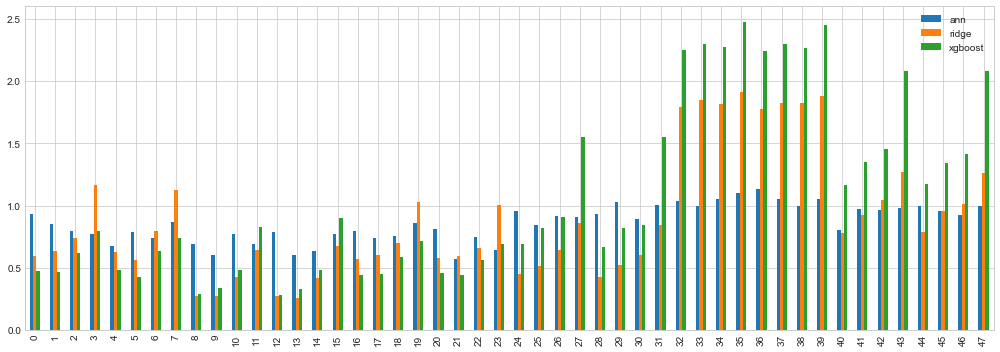

In [43]:
test_df['num_sold'] = 0
scores_df = pd.DataFrame({})
scaler = StandardScaler()

for model_name in list(model_map.keys()):
    scores_list = []
    
    print(f'model {model_name} is training ...')
    for country, i in zip(train_df['country'].unique(), range(6)):
        for store, k in zip(train_df['store'].unique(), range(2)):
            for product, j in zip(train_df['product'].unique(), range(4)):
                temp_df = None
                temp_df = train_df.loc[(train_df['country']==country)&
                                          (train_df['store']==store)&
                                          (train_df['product']==product),
                                          ['date', 'num_sold']
                                         ]

                temp_test_df = test_df.loc[(test_df['country']==country)&
                                          (test_df['store']==store)&
                                          (test_df['product']==product),
                                          ['date', 'num_sold']
                                         ]


                temp_df_all = feature_engineer(temp_df)
                test_df_all = feature_engineer(temp_test_df)
                temp_df_all = pd.DataFrame(scaler.fit_transform(temp_df_all), columns=temp_df_all.columns, index=temp_df_all.index)
                test_df_all = pd.DataFrame(scaler.transform(test_df_all), columns=test_df_all.columns, index=test_df_all.index)
                
                y = temp_df_all["num_sold"]
                X = temp_df_all.drop(columns="num_sold")
                X_test = test_df_all.drop('num_sold', axis=1)

                y_pred, y_fore, scores = model_score(X, y, X_test, model_name)
                scores_list.append(np.mean(scores))
                
    scores_df[model_name] = scores_list
    
_, ax = plt.subplots(figsize=(14, 5))
scores_df.plot(kind='bar', ax=ax)

Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 22: ear

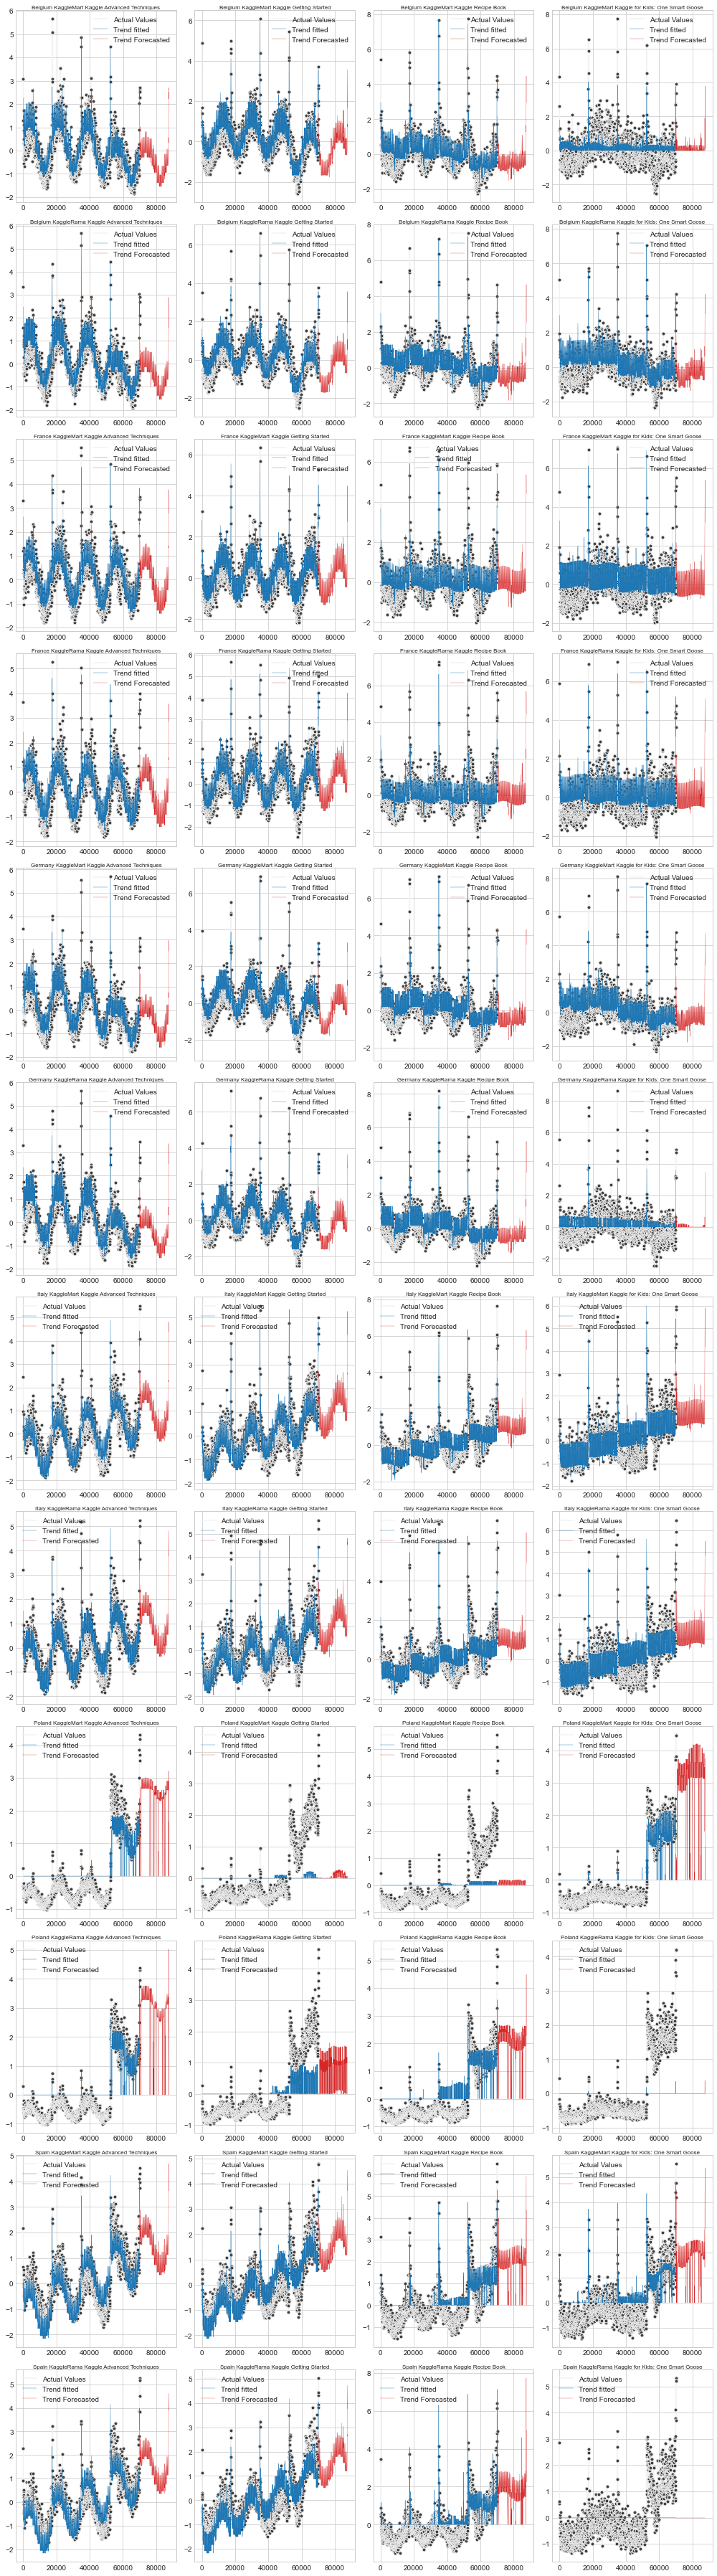

In [44]:
_, ax = plt.subplots(12, 4, figsize=(14, 50))
h = 0

for country, i in zip(train_df['country'].unique(), range(6)):
    for store, k in zip(train_df['store'].unique(), range(2)):
        for product, j in zip(train_df['product'].unique(), range(4)):
            temp_df = None
            temp_test_df = None
            temp_df = train_df.loc[(train_df['country']==country)&
                                      (train_df['store']==store)&
                                      (train_df['product']==product),
                                      ['date', 'num_sold']
                                     ]

            temp_test_df = test_df.loc[(test_df['country']==country)&
                                      (test_df['store']==store)&
                                      (test_df['product']==product),
                                      ['date', 'num_sold']
                                     ]


            temp_df_all = feature_engineer(temp_df)
            test_df_all = feature_engineer(temp_test_df)
            temp_df_all = pd.DataFrame(scaler.fit_transform(temp_df_all), columns=temp_df_all.columns, index=temp_df_all.index)
            test_df_all = pd.DataFrame(scaler.transform(test_df_all), columns=test_df_all.columns, index=test_df_all.index)

            y = temp_df_all["num_sold"]
            X = temp_df_all.drop(columns="num_sold")
            X_test = test_df_all.drop('num_sold', axis=1)
            
            model_name = scores_df.idxmin(axis=1)[h]
            y_pred, y_fore, scores = model_score(X, y, X_test, model_name)
            h += 1
            
            y_pred = pd.Series(y_pred.squeeze(), index=X.index)         
            y_fore = pd.Series(y_fore.squeeze(), index=X_test.index)
            y.plot(ax=ax[i*2+k, j], color='0.95', style='.-',markerfacecolor="0.25", markersize=10, title=f'{country} {store} {product}',label='Actual Values', legend=True, xlabel='')
            y_pred.plot(ax=ax[i*2+k, j], linewidth=0.4, label="Trend fitted", legend=True, xlabel='')
            y_fore.plot(ax=ax[i*2+k, j], linewidth=0.3, label="Trend Forecasted", color="C3", legend=True, xlabel='')
            
            test_df_all['num_sold'] = np.array(y_fore)
            test_df_all = pd.DataFrame(scaler.inverse_transform(test_df_all), columns=test_df_all.columns, index=test_df_all.index)
            test_df.loc[(test_df['country']==country) & (test_df['store']==store) & (test_df['product']==product), ['num_sold']] = test_df_all['num_sold']

In [47]:
sub_df['num_sold'] = np.array(test_df['num_sold'])
sub_df.to_csv('Subm5.csv', index=False)